<a href="https://colab.research.google.com/github/vitamingyu/NLP-LLM/blob/main/tf_52ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# LFW dataset 사용 : 칼라 사람 얼굴 이미지
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm

In [37]:
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

# 원시 행렬을 이미지로 변환하고 색상을 RGB로 변경
def decode_img_raw_bytes(raw_bytes):
  img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# 데이터를 읽어 조정
def load_lfw_data(use_raw=False, dx=80, dy=80, dimx=45, dimy=45):
  df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
  df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
  imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))
  # print(imgs_with_attrs) # {('Oscar De La Hoya', 4), ('Antony Leung', 3), ('Kim Yong-il', 2),...

  # read photo
  all_photo = []
  photo_ids = []

  with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as obj:
    for m in tqdm.tqdm_notebook(obj.getmembers()):
      if m.isfile() and m.name.endswith(".jpg"):  # 압축된 데이터에서 이미지 파일만 처리
        img = decode_img_raw_bytes(obj.extractfile(m).read())
        # print(img)
        # 얼굴 부위만 자르고 크기 조정
        img = img[dy:-dy, dx:-dx]
        img = cv2.resize(img, (dimx, dimy))

        # 사람을 구문 분석하고 수집된 데이터에 추가
        fname = os.path.split(m.name)[-1]
        fname_splitted = fname[:-4].replace('_', ' ').split()
        # print(fname, fname_splitted)
        person_id = ' '.join(fname_splitted[:-1])
        photo_number = int(fname_splitted[-1])
        if (person_id, photo_number) in imgs_with_attrs:
          all_photo.append(img)
          photo_ids.append({'person':person_id,'imagenum':photo_number})

  pho_ids = pd.DataFrame(photo_ids)
  all_photos = np.stack(all_photo).astype('uint8')

  all_attrs = pho_ids.merge(df_attrs, on=('person','imagenum')).drop(['person','imagenum'], axis=1)
  return all_photos, all_attrs

<ipython-input-37-66d3db5d121c>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(obj.getmembers()):


  0%|          | 0/18983 [00:00<?, ?it/s]

0.5 -0.5


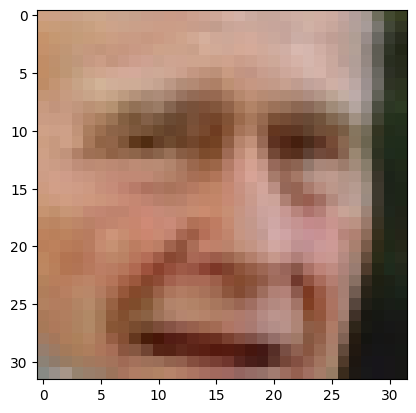

In [38]:
# autoencoder 구현
x, attr = load_lfw_data(use_raw=True, dimx=32, dimy=32)
x = x.astype('float32') / 255.0 - 0.5
print(x.max(), x.min())  # 최소값과 배열 최대값

import matplotlib.pyplot as plt
def show_image(x):
  plt.imshow(np.clip(x + 0.5, 0, 1))  #  array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수.

show_image(x[6])
plt.show()

In [41]:
# train / test split
from sklearn.model_selection import train_test_split

x_train,x_test= train_test_split(x,test_size=0.1,random_state=42) #autoencoder는 비지도 학습이다.
print(x_train.shape,x_test.shape) # (11828, 32, 32, 3) (1315, 32, 32, 3)

from keras.layers import Dense,Flatten,Reshape,Input,InputLayer
from keras.models import Sequential,Model

def build_autoencoder(img_shape, code_size):
    # Encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())  # 이미지를 1D 배열로 변환
    encoder.add(Dense(code_size))

    # Decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))  # 32*32*3으로 fully connected layer 생성
    decoder.add(Reshape(img_shape))  # 이미지 형태로 변환

    return encoder, decoder

IMG_SHAPE = x.shape[1:]  # (32, 32, 3)
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)  # 인코더와 디코더 생성

inp = Input(IMG_SHAPE)
code = encoder(inp)  # 인코더의 출력을 얻음
reconstruction = decoder(code)  # 디코더에 코드를 입력하여 재구성

autoencoder = Model(inp, reconstruction)
# 오토인코더 컴파일
autoencoder.compile(optimizer='adamax', loss='mse')  # 손실 함수는 Mean Squared Error
print(autoencoder.summary())  # 모델 요약 출력
#adam의 변형인 adammax는 1차 기울기 기반 최적화 방법
#데이터의 특성에 따라 학습률을 조정하는 기능으로 인해 시변 프로세스를 학습
# 임베딩이 있는 모델에서 Adam보다 우수하다고 알려짐

history=autoencoder.fit(x=x_train,y=x_train, epochs=30, validation_data=[x_test,x_test])

(11828, 32, 32, 3) (1315, 32, 32, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32)                98336     
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         101376    
                                                                 
Total params: 199712 (780.12 KB)
Trainable params: 199712 (780.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
370/370 [==============================] - 4s 4ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 2/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 3/30
370/370 [=======================

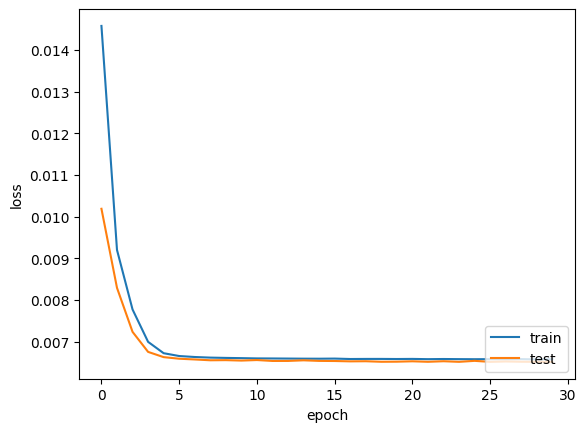

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

1/1 [==============================] - 0s 39ms/step


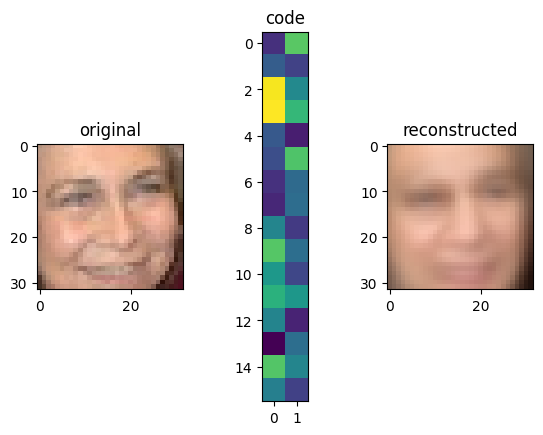

1/1 [==============================] - 0s 18ms/step


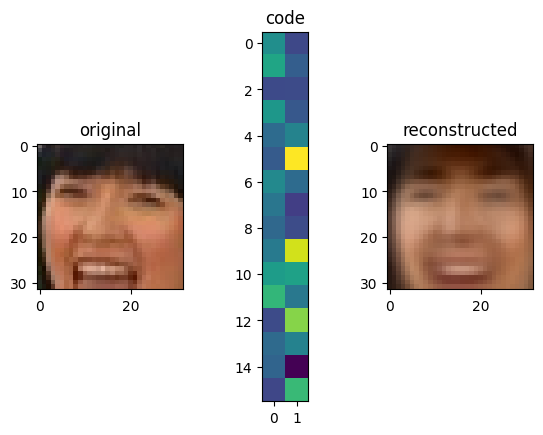

1/1 [==============================] - 0s 16ms/step


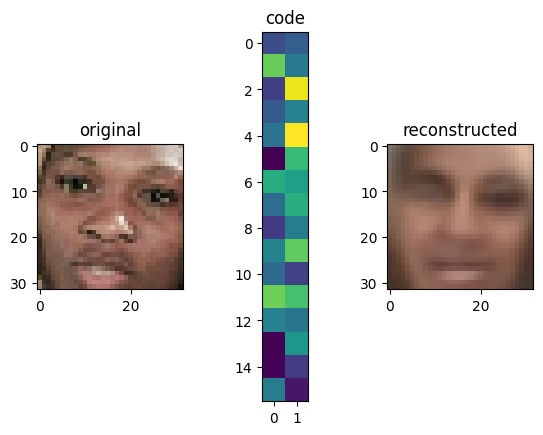

1/1 [==============================] - 0s 17ms/step


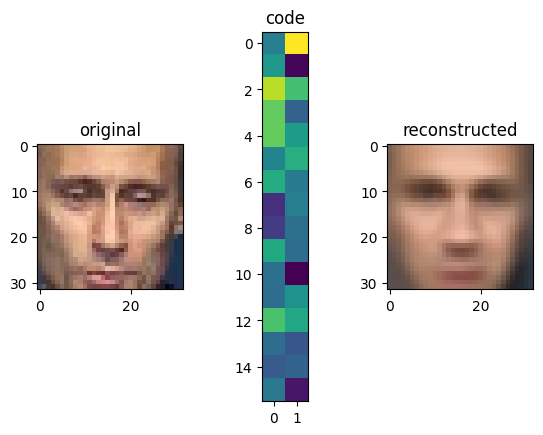

1/1 [==============================] - 0s 24ms/step


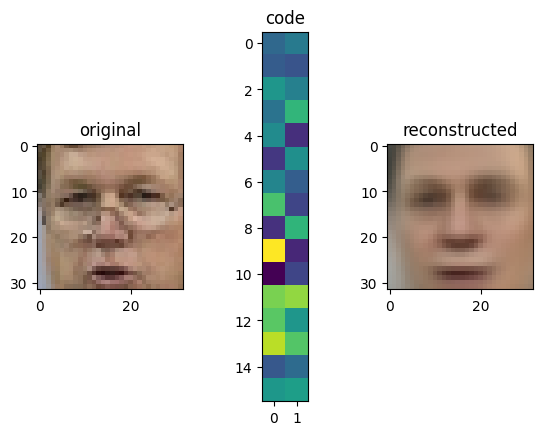

In [43]:
# 결과를 시각화
def showFunc(img, encoder, decoder):
  # 원본, 인코딩 및 디코딩 이미지 출력
  code = encoder.predict(img[None])[0]  # img[None]은 모델입력과 동일한 (1, 32, 32, 3) 모양을 갖음
  reco = decoder.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title('original')
  show_image(img)

  plt.subplot(1,3,2)
  plt.title('code')
  plt.imshow(code.reshape([code.shape[-1] // 2, -1]))

  plt.subplot(1,3,3)
  plt.title('reconstructed')
  show_image(reco)

  plt.show()


for i in range(5):
  img = x_test[i]
  showFunc(img, encoder, decoder)